In [1]:
import torch
import triton
import triton.language as tl
from causal_conv1d import causal_conv1d_fn
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
# from mamba_ssm import mamba_inner_fn
from copy import deepcopy

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


# v1

In [2]:

# @triton.autotune([triton.Config({"BLOCK_SIZE_L":bsl, "BLOCK_SIZE_D":bsd}, num_stages=ns, num_warps=nw)
#                                  for bsl in [32, 64, 128]
#                                  for bsd in [32, 64, 128]
#                                  for ns in [1,2,3,4]
#                                  for nw in [4,8]], key=['L', 'D'])
@triton.jit
def _conv1d_fwd_kernel(X, W, Y, BIAS, HAVE_BIAS,
                       stride_xb, stride_xd, stride_xl,
                       stride_yb, stride_yd, stride_yl,
                       stride_wd, stride_wk,
                       B, D, L, K, 
                       BLOCK_SIZE_L:tl.constexpr=64, BLOCK_SIZE_D:tl.constexpr=128,
                       num_stages: tl.constexpr=3,
                        ):
    off_b = tl.program_id(0)
    off_d = tl.program_id(1) * BLOCK_SIZE_D
    off_l = tl.program_id(2) * BLOCK_SIZE_L

    X += off_b * stride_xb 
    Y += off_b * stride_yb
    # kk = tl.arange(0, BLOCK_SIZE_K)
    dd = tl.arange(0, BLOCK_SIZE_D)
    ll = tl.arange(0, BLOCK_SIZE_L)
    rows = off_d + dd
    cols = off_l + ll - K
    x_ptrs = X + rows[:, None] * stride_xd + cols[None, :] * stride_xl 
    
    w_ptrs = W + rows * stride_wd
    row_mask = rows < D

    acc = tl.zeros((BLOCK_SIZE_D, BLOCK_SIZE_L), dtype=tl.float32)
    for _ in tl.range(K):
        w = tl.load(w_ptrs, mask=row_mask, other=0.).to(tl.float32)
        cols += 1
        x_ptrs += stride_xl
        col_mask = (cols >= 0) & (cols < L)
        x = tl.load(x_ptrs, mask=col_mask[None, :] & row_mask[:, None], other=0.).to(tl.float32)
        acc += x * w[:, None]
        w_ptrs += stride_wk 
    if HAVE_BIAS:
        bias = tl.load(BIAS+rows, mask=row_mask, other=0.).to(tl.float32)
        acc += bias[:, None]
    y_ptrs = Y + rows[:, None] * stride_yd + (off_l + ll)[None, :] * stride_yl
    col_mask = off_l + ll<L
    tl.store(y_ptrs, acc, mask=col_mask[None, :] & row_mask[:, None])

# @triton.autotune([triton.Config({"BLOCK_SIZE_D":bsd}, num_stages=ns, num_warps=nw)
#                                 #  for bsl in [32, 64, 128]
#                                  for bsd in [16, 32, 64, 128]
#                                  for ns in [1,2,3,4]
#                                  for nw in [4,8]], key=['L', 'D'])
@triton.jit
def _conv1d_bwd_kernel(DY, DX, DW,
                        X, W,
                       stride_dyb, stride_dyd, stride_dyl,
                       stride_dxb, stride_dxd, stride_dxl,
                       stride_xb, stride_xd, stride_xl,
                       stride_wd, stride_wk,
                       stride_dwb, stride_dwd, stride_dwk,
                       B, D, L, K,
                       BLOCK_SIZE_L:tl.constexpr, BLOCK_SIZE_D:tl.constexpr=16,
                       num_warps:tl.constexpr=4, num_stages: tl.constexpr=4,
                        ):
    off_b = tl.program_id(0)
    off_d = tl.program_id(1) * BLOCK_SIZE_D
    off_l = tl.program_id(2) * BLOCK_SIZE_L
    b = tl.cdiv(L, BLOCK_SIZE_L)

    X += off_b * stride_xb 
    DY += off_b * stride_dyb
    DX += off_b * stride_dxb
    DW += (off_b * b + tl.program_id(2)) * stride_dwb
    dd = tl.arange(0, BLOCK_SIZE_D)
    ll = tl.arange(0, BLOCK_SIZE_L)
    rows = off_d + dd
    cols = off_l + ll + K
    col_mask_x = off_l + ll < L
    x_ptrs = X + rows[:, None] * stride_xd + (off_l + ll)[None, :] * stride_xl 
    dx_ptrs = DX + rows[:, None] * stride_dxd + cols[None, :] * stride_dxl
    dy_ptrs = DY + rows[:, None] * stride_dyd + cols[None, :] * stride_dyl
    w_ptrs = W + rows * stride_wd
    dw_ptrs = DW + rows * stride_dwd
    row_mask = rows < D

    x = tl.load(x_ptrs, mask=col_mask_x[None, :] & row_mask[:, None], other=0.).to(tl.float32)
    acc_dx = tl.zeros((BLOCK_SIZE_D, BLOCK_SIZE_L), dtype=tl.float32)
    for idx in tl.range(K):
        w = tl.load(w_ptrs, mask=row_mask, other=0.).to(tl.float32)
        cols -= 1

        dy_ptrs -= stride_dyl
        col_mask = (cols >= 0) & (cols < L)
        
        dy = tl.load(dy_ptrs, mask=col_mask[None, :] & row_mask[:, None], other=0.).to(tl.float32)
        acc_dx += dy * w[:, None]
        dw = tl.sum(dy * x, 1)
        tl.store(dw_ptrs, dw, mask=row_mask)
        w_ptrs += stride_wk
        dw_ptrs += stride_dwk

    dx_ptrs = DX + rows[:, None] * stride_dxd + cols[None, :] * stride_dxl
    tl.store(dx_ptrs, acc_dx, mask=col_mask_x[None, :] & row_mask[:, None])

class _TritonCausalConv1dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias=None):
        # print(weight.shape, x.shape)
        D, K = weight.shape
        B, D, L = x.shape
        y = torch.empty_like(x)
        HAVE_BIAS = True 
        ctx.bias = bias
        if bias is None:
            bias = weight
            HAVE_BIAS = False
        grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), triton.cdiv(L,meta['BLOCK_SIZE_L']))
        _conv1d_fwd_kernel[grid](x, weight, y, bias, HAVE_BIAS,
                                *x.stride(),
                                *y.stride(),
                                *weight.stride(),
                                B, D, L, K,
                                )
        
        ctx.save_for_backward(x, weight)
        return y
    
    @staticmethod
    def backward(ctx, dy):
        x, weight = ctx.saved_tensors
        D, K = weight.shape
        B, D, L = x.shape
        BLOCK_SIZE_L = 128
        # a = triton.cdiv(D, BLOCK_SIZE_D)
        b = triton.cdiv(L, BLOCK_SIZE_L)
        dx = torch.empty_like(dy)
        dw = torch.empty(B*b, D, K, dtype=x.dtype, device=x.device)
        grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), b)
        _conv1d_bwd_kernel[grid](dy, dx, dw,
                                x, weight,
                                *dy.stride(),
                                *dx.stride(),
                                *x.stride(),
                                *weight.stride(),
                                *dw.stride(),
                                B, D, L, K,
                                BLOCK_SIZE_L, 
                                # BLOCK_SIZE_D,
                                # num_warps=4, num_stages=1
                                )
        dw = dw.sum(0)
        dbias = None
        if ctx.bias is not None:
            dbias = dy.transpose(-1,-2).reshape(-1, D).sum(0)
        return dx, dw, dbias
    
triton_causal_conv1d = _TritonCausalConv1dFunction.apply

# v2

In [54]:

# @triton.autotune([triton.Config({"BLOCK_SIZE_L":bsl, "BLOCK_SIZE_D":bsd}, num_stages=ns, num_warps=nw)
#                                  for bsl in [32, 64, 128]
#                                  for bsd in [32, 64, 128]
#                                  for ns in [1,2,3,4]
#                                  for nw in [4,8]], key=['L', 'D'])
@triton.jit
def _conv1d_fwd_kernel2(X, W, Y, BIAS, HAVE_BIAS,
                       stride_xb, stride_xd, stride_xl,
                       stride_yb, stride_yd, stride_yl,
                       stride_wd, stride_wk,
                       B, D, L, K, 
                       BLOCK_SIZE_L:tl.constexpr=64, BLOCK_SIZE_D:tl.constexpr=128,
                       num_stages: tl.constexpr=3,
                        ):
    off_b = tl.program_id(0)
    off_d = tl.program_id(1) * BLOCK_SIZE_D
    off_l = tl.program_id(2) * BLOCK_SIZE_L

    X += off_b * stride_xb 
    Y += off_b * stride_yb
    # kk = tl.arange(0, BLOCK_SIZE_K)
    dd = tl.arange(0, BLOCK_SIZE_D)
    ll = tl.arange(0, BLOCK_SIZE_L)
    rows = off_d + dd
    cols = off_l + ll - K
    x_ptrs = X + rows[:, None] * stride_xd + cols[None, :] * stride_xl 
    
    w_ptrs = W + rows * stride_wd
    row_mask = rows < D

    acc = tl.zeros((BLOCK_SIZE_D, BLOCK_SIZE_L), dtype=tl.float32)
    for _ in tl.range(K):
        w = tl.load(w_ptrs, mask=row_mask, other=0.).to(tl.float32)
        cols += 1
        x_ptrs += stride_xl
        col_mask = (cols >= 0) & (cols < L)
        x = tl.load(x_ptrs, mask=col_mask[None, :] & row_mask[:, None], other=0.).to(tl.float32)
        acc += x * w[:, None]
        w_ptrs += stride_wk 
    if HAVE_BIAS:
        bias = tl.load(BIAS+rows, mask=row_mask, other=0.).to(tl.float32)
        acc += bias[:, None]
    y_ptrs = Y + rows[:, None] * stride_yd + (off_l + ll)[None, :] * stride_yl
    col_mask = off_l + ll<L
    tl.store(y_ptrs, acc, mask=col_mask[None, :] & row_mask[:, None])

@triton.autotune([triton.Config({"BLOCK_SIZE_D":bsd}, num_stages=ns, num_warps=nw)
                                #  for bsl in [32, 64, 128]
                                 for bsd in [16, 32, 64, 128]
                                 for ns in [1,2,3,4]
                                 for nw in [4,8]], key=['L', 'D'])
@triton.jit
def _conv1d_bwd_kernel2(DY, DX, DW,
                        X, W,
                       stride_dyb, stride_dyd, stride_dyl,
                       stride_dxb, stride_dxd, stride_dxl,
                       stride_xb, stride_xd, stride_xl,
                       stride_wd, stride_wk,
                       stride_dwb, stride_dwd, stride_dwk,
                       B, D, L, K,
                       BLOCK_SIZE_L:tl.constexpr, BLOCK_SIZE_K:tl.constexpr, 
                       BLOCK_SIZE_D:tl.constexpr=16,
                       num_warps:tl.constexpr=4, num_stages: tl.constexpr=4,
                        ):
    off_b = tl.program_id(0)
    off_d = tl.program_id(1) * BLOCK_SIZE_D
    off_l = tl.program_id(2) * BLOCK_SIZE_L
    b = tl.cdiv(L, BLOCK_SIZE_L)

    X += off_b * stride_xb 
    DY += off_b * stride_dyb
    DX += off_b * stride_dxb
    DW += (off_b * b + tl.program_id(2)) * stride_dwb
    dd = tl.arange(0, BLOCK_SIZE_D)
    ll = tl.arange(0, BLOCK_SIZE_L)
    kk = tl.arange(0, BLOCK_SIZE_K)

    rows = off_d + dd
    cols = off_l + ll
    col_mask = cols < L
    x_ptrs = X + rows[:, None] * stride_xd + cols[None, :] * stride_xl 
    dx_ptrs = DX + rows[:, None] * stride_dxd + cols[None, :] * stride_dxl
    k_mask = kk < K
    tmp = cols[:, None] + BLOCK_SIZE_K - 1 - kk[None, :] 
    dy_ptrs = DY + rows[:, None, None] * stride_dyd + tmp[None, :, :] * stride_dyl
    dy_mask = (tmp >= 0) & (tmp < L) & k_mask[None, :]
    w_ptrs = W + rows[:, None] * stride_wd + kk[None, :] * stride_wk
    dw_ptrs = DW + rows[:, None] * stride_dwd + kk[None, :] * stride_dwk
    row_mask = rows < D
    
    x = tl.load(x_ptrs, mask=col_mask[None, :] & row_mask[:, None], other=0.).to(tl.float32)
    w = tl.load(w_ptrs, mask=row_mask[:, None] & k_mask[None, :], other=0.).to(tl.float32)
    
    dy = tl.load(dy_ptrs, mask=dy_mask[None, :, :] & row_mask[:, None, None], other=0.).to(tl.float32)
    dx = tl.sum(dy * w[:, None, :], 2)
    dw = tl.sum(dy * x[:, :, None], 1)
    
    tl.store(dw_ptrs, dw, mask=row_mask[:,None] & k_mask[None, :])
    tl.store(dx_ptrs, dx, mask=col_mask[None, :] & row_mask[:, None])

class _TritonCausalConv1dFunction2(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias=None):
        # print(weight.shape, x.shape)
        D, K = weight.shape
        B, D, L = x.shape
        y = torch.empty_like(x)
        HAVE_BIAS = True 
        ctx.bias = bias
        if bias is None:
            bias = weight
            HAVE_BIAS = False
        grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), triton.cdiv(L,meta['BLOCK_SIZE_L']))
        _conv1d_fwd_kernel[grid](x, weight, y, bias, HAVE_BIAS,
                                *x.stride(),
                                *y.stride(),
                                *weight.stride(),
                                B, D, L, K,
                                )
        
        ctx.save_for_backward(x, weight)
        return y
    
    @staticmethod
    def backward(ctx, dy):
        x, weight = ctx.saved_tensors
        D, K = weight.shape
        B, D, L = x.shape
        BLOCK_SIZE_L = 64
        # a = triton.cdiv(D, BLOCK_SIZE_D)
        b = triton.cdiv(L, BLOCK_SIZE_L)
        dx = torch.empty_like(dy)
        dw = torch.empty(B*b, D, K, dtype=x.dtype, device=x.device)
        grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), b)
        _conv1d_bwd_kernel[grid](dy, dx, dw,
                                x, weight,
                                *dy.stride(),
                                *dx.stride(),
                                *x.stride(),
                                *weight.stride(),
                                *dw.stride(),
                                B, D, L, K,
                                BLOCK_SIZE_L, triton.next_power_of_2(K),
                                # BLOCK_SIZE_D,
                                # num_warps=4, num_stages=1
                                )
        dw = dw.sum(0)
        dbias = None
        if ctx.bias is not None:
            dbias = dy.transpose(-1,-2).reshape(-1, D).sum(0)
        return dx, dw, dbias
    
triton_causal_conv1d2 = _TritonCausalConv1dFunction2.apply

# v3

In [3]:

# @triton.autotune([triton.Config({"BLOCK_SIZE_L":bsl, "BLOCK_SIZE_D":bsd}, num_stages=ns, num_warps=nw)
#                                  for bsl in [32, 64, 128]
#                                  for bsd in [32, 64, 128]
#                                  for ns in [1,2,3,4]
#                                  for nw in [4,8]], key=['L', 'D'])
@triton.jit
def _conv1d_fwd_kernel(X, W, Y, BIAS, HAVE_BIAS,
                       stride_xb, stride_xd, stride_xl,
                       stride_yb, stride_yd, stride_yl,
                       stride_wd, stride_wk,
                       B, D, L, K, ACT,
                       BLOCK_SIZE_L:tl.constexpr=64, BLOCK_SIZE_D:tl.constexpr=128,
                       num_stages: tl.constexpr=3,
                        ):
    off_b = tl.program_id(0)
    off_d = tl.program_id(1) * BLOCK_SIZE_D
    off_l = tl.program_id(2) * BLOCK_SIZE_L

    X += off_b * stride_xb 
    Y += off_b * stride_yb
    # kk = tl.arange(0, BLOCK_SIZE_K)
    dd = tl.arange(0, BLOCK_SIZE_D)
    ll = tl.arange(0, BLOCK_SIZE_L)
    rows = off_d + dd
    cols = off_l + ll - K
    x_ptrs = X + rows[:, None] * stride_xd + cols[None, :] * stride_xl 
    
    w_ptrs = W + rows * stride_wd
    row_mask = rows < D

    acc = tl.zeros((BLOCK_SIZE_D, BLOCK_SIZE_L), dtype=tl.float32)
    for _ in tl.range(K):
        w = tl.load(w_ptrs, mask=row_mask, other=0.).to(tl.float32)
        cols += 1
        x_ptrs += stride_xl
        col_mask = (cols >= 0) & (cols < L)
        x = tl.load(x_ptrs, mask=col_mask[None, :] & row_mask[:, None], other=0.).to(tl.float32)
        acc += x * w[:, None]
        w_ptrs += stride_wk 
    if HAVE_BIAS:
        bias = tl.load(BIAS+rows, mask=row_mask, other=0.).to(tl.float32)
        acc += bias[:, None]
    if ACT:
        acc *= tl.sigmoid(acc)
    y_ptrs = Y + rows[:, None] * stride_yd + (off_l + ll)[None, :] * stride_yl
    col_mask = off_l + ll < L
    tl.store(y_ptrs, acc, mask=col_mask[None, :] & row_mask[:, None])

@triton.jit
def _conv1d_bwd_dz_kernel(X, W, DY, DZ, BIAS, HAVE_BIAS,
                       stride_xb, stride_xd, stride_xl,
                       stride_yb, stride_yd, stride_yl,
                       stride_wd, stride_wk,
                       B, D, L, K, 
                       BLOCK_SIZE_L:tl.constexpr=64, BLOCK_SIZE_D:tl.constexpr=128,
                       num_stages: tl.constexpr=3,
                        ):
    off_b = tl.program_id(0)
    off_d = tl.program_id(1) * BLOCK_SIZE_D
    off_l = tl.program_id(2) * BLOCK_SIZE_L

    X += off_b * stride_xb 
    DY += off_b * stride_yb
    DZ += off_b * stride_yb

    # kk = tl.arange(0, BLOCK_SIZE_K)
    dd = tl.arange(0, BLOCK_SIZE_D)
    ll = tl.arange(0, BLOCK_SIZE_L)
    rows = off_d + dd
    cols = off_l + ll - K
    x_ptrs = X + rows[:, None] * stride_xd + cols[None, :] * stride_xl 
    
    w_ptrs = W + rows * stride_wd
    row_mask = rows < D

    acc = tl.zeros((BLOCK_SIZE_D, BLOCK_SIZE_L), dtype=tl.float32)
    for _ in tl.range(K):
        w = tl.load(w_ptrs, mask=row_mask, other=0.).to(tl.float32)
        cols += 1
        x_ptrs += stride_xl
        col_mask = (cols >= 0) & (cols < L)
        x = tl.load(x_ptrs, mask=col_mask[None, :] & row_mask[:, None], other=0.).to(tl.float32)
        acc += x * w[:, None]
        w_ptrs += stride_wk 
    if HAVE_BIAS:
        bias = tl.load(BIAS+rows, mask=row_mask, other=0.).to(tl.float32)
        acc += bias[:, None]

    sig_acc = tl.sigmoid(acc)
    dy_ptrs = DY + rows[:, None] * stride_yd + (off_l + ll)[None, :] * stride_yl
    dz_ptrs = DZ + rows[:, None] * stride_yd + (off_l + ll)[None, :] * stride_yl
    col_mask = off_l + ll<L
    dy = tl.load(dy_ptrs, mask=col_mask[None, :] & row_mask[:, None], other=0.)
    dz = (sig_acc + acc * sig_acc * (1 - sig_acc)) * dy
    tl.store(dz_ptrs, dz, mask=col_mask[None, :] & row_mask[:, None])

# @triton.autotune([triton.Config({"BLOCK_SIZE_D":bsd}, num_stages=ns, num_warps=nw)
#                                 #  for bsl in [32, 64, 128]
#                                  for bsd in [16, 32, 64, 128]
#                                  for ns in [1,2,3,4]
#                                  for nw in [4,8]], key=['L', 'D'])
@triton.jit
def _conv1d_bwd_dwdb_kernel(DY, DX, DW,
                        X, W, DB, HAVE_BIAS,
                       stride_dyb, stride_dyd, stride_dyl,
                       stride_dxb, stride_dxd, stride_dxl,
                       stride_xb, stride_xd, stride_xl,
                       stride_wd, stride_wk,
                       stride_dwb, stride_dwd, stride_dwk,
                       B, D, L, K, ACT,
                       BLOCK_SIZE_L:tl.constexpr, BLOCK_SIZE_D:tl.constexpr=16,
                       num_warps:tl.constexpr=4, num_stages: tl.constexpr=4,
                        ):
    off_b = tl.program_id(0)
    off_d = tl.program_id(1) * BLOCK_SIZE_D
    off_l = tl.program_id(2) * BLOCK_SIZE_L
    b = tl.cdiv(L, BLOCK_SIZE_L)

    X += off_b * stride_xb 
    DY += off_b * stride_dyb
    DX += off_b * stride_dxb
    DW += (off_b * b + tl.program_id(2)) * stride_dwb
    dd = tl.arange(0, BLOCK_SIZE_D)
    ll = tl.arange(0, BLOCK_SIZE_L)
    rows = off_d + dd
    cols = off_l + ll + K
    col_mask_x = off_l + ll < L
    x_ptrs = X + rows[:, None] * stride_xd + (off_l + ll)[None, :] * stride_xl 
    dx_ptrs = DX + rows[:, None] * stride_dxd + cols[None, :] * stride_dxl
    dy_ptrs = DY + rows[:, None] * stride_dyd + cols[None, :] * stride_dyl
    w_ptrs = W + rows * stride_wd
    dw_ptrs = DW + rows * stride_dwd
    row_mask = rows < D

    x = tl.load(x_ptrs, mask=col_mask_x[None, :] & row_mask[:, None], other=0.).to(tl.float32)
    acc_dx = tl.zeros((BLOCK_SIZE_D, BLOCK_SIZE_L), dtype=tl.float32)
    for idx in tl.range(K):
        w = tl.load(w_ptrs, mask=row_mask, other=0.).to(tl.float32)
        cols -= 1

        dy_ptrs -= stride_dyl
        col_mask = (cols >= 0) & (cols < L)
        
        dy = tl.load(dy_ptrs, mask=col_mask[None, :] & row_mask[:, None], other=0.).to(tl.float32)
        acc_dx += dy * w[:, None]
        dw = tl.sum(dy * x, 1)
        tl.store(dw_ptrs, dw, mask=row_mask)
        w_ptrs += stride_wk
        dw_ptrs += stride_dwk
        if idx == K-1 and HAVE_BIAS:
            DB += (off_b * b + tl.program_id(2)) * stride_dwb // K
            tl.store(DB+rows, tl.sum(dy, 1), mask=row_mask)

    dx_ptrs = DX + rows[:, None] * stride_dxd + cols[None, :] * stride_dxl
    tl.store(dx_ptrs, acc_dx, mask=col_mask_x[None, :] & row_mask[:, None])


def causal_conv1d_fwd(x, weight, bias=None, unuse_arg1=None, unuse_arg2=None, unuse_arg3=None, activation=False):
    D, K = weight.shape
    B, D, L = x.shape
    y = torch.empty_like(x)
    HAVE_BIAS = bias is not None
    grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), triton.cdiv(L,meta['BLOCK_SIZE_L']))
    # print(activation is not None, activation)
    _conv1d_fwd_kernel[grid](x, weight, y, bias if HAVE_BIAS else weight, HAVE_BIAS,
                            *x.stride(),
                            *y.stride(),
                            *weight.stride(),
                            B, D, L, K, activation,
                            )
    return y
    
def causal_conv1d_bwd(x, weight, bias, dy, seq_idx=None, unuse_arg1=None, unuse_arg2=None, dx=None, unuse_arg3=None, activation=False):
    D, K = weight.shape
    B, D, L = x.shape
    HAVE_BIAS = bias is not None
    if activation:
        dz = torch.empty_like(x)
        grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), triton.cdiv(L,meta['BLOCK_SIZE_L']))
        # print(activation is not None, activation)
        _conv1d_bwd_dz_kernel[grid](x, weight, dy, dz, bias if HAVE_BIAS else weight, HAVE_BIAS,
                                *x.stride(),
                                *dz.stride(),
                                *weight.stride(),
                                B, D, L, K, 
                                )
    BLOCK_SIZE_L = 128
    # a = triton.cdiv(D, BLOCK_SIZE_D)
    b = triton.cdiv(L, BLOCK_SIZE_L)
    if dx is None:
        dx = torch.empty_like(dy)
    dw = torch.empty(B*b, D, K, dtype=x.dtype, device=x.device)
    db = None
    if HAVE_BIAS:
        db = torch.empty(B*b, D, dtype=x.dtype, device=x.device)
    grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), b)
    _conv1d_bwd_dwdb_kernel[grid](dz if activation else dy, dx, dw,
                            x, weight, db if HAVE_BIAS else dw, HAVE_BIAS,
                            *dy.stride(),
                            *dx.stride(),
                            *x.stride(),
                            *weight.stride(),
                            *dw.stride(),
                            B, D, L, K, activation,
                            BLOCK_SIZE_L, 
                            # BLOCK_SIZE_D,
                            # num_warps=4, num_stages=1
                            )
    dw = dw.sum(0)
    if HAVE_BIAS:
        db = db.sum(0)
    return dx, dw, db, None

class _TritonCausalConv1dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias=None, activation=None):
        assert activation in [None, 'silu', 'swish']
        # # print(weight.shape, x.shape)
        # D, K = weight.shape
        # B, D, L = x.shape
        # y = torch.empty_like(x)
        # HAVE_BIAS = bias is not None
        # grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), triton.cdiv(L,meta['BLOCK_SIZE_L']))
        # # print(activation is not None, activation)
        # _conv1d_fwd_kernel[grid](x, weight, y, bias if HAVE_BIAS else weight, HAVE_BIAS,
        #                         *x.stride(),
        #                         *y.stride(),
        #                         *weight.stride(),
        #                         B, D, L, K, activation is not None,
        #                         )
        ctx.activation = activation in ['silu', 'swish']
        y = causal_conv1d_fwd(x, weight, bias, None, None, None, ctx.activation)
        ctx.save_for_backward(x, weight)
        ctx.bias = bias
        return y
    
    @staticmethod
    def backward(ctx, dy):
        x, weight = ctx.saved_tensors
        # D, K = weight.shape
        # B, D, L = x.shape
        # HAVE_BIAS = ctx.bias is not None
        # if ctx.activation is not None:
        #     dz = torch.empty_like(x)
        #     grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), triton.cdiv(L,meta['BLOCK_SIZE_L']))
        #     # print(activation is not None, activation)
        #     _conv1d_bwd_dz_kernel[grid](x, weight, dy, dz, ctx.bias if HAVE_BIAS else weight, HAVE_BIAS,
        #                             *x.stride(),
        #                             *dz.stride(),
        #                             *weight.stride(),
        #                             B, D, L, K, 
        #                             )
        # BLOCK_SIZE_L = 128
        # a = triton.cdiv(D, BLOCK_SIZE_D)
        # b = triton.cdiv(L, BLOCK_SIZE_L)
        # dx = torch.empty_like(dy)
        # dw = torch.empty(B*b, D, K, dtype=x.dtype, device=x.device)
        # db = None
        # if ctx.bias is not None:
        #     db = torch.empty(B*b, D, dtype=x.dtype, device=x.device)
        # grid = lambda meta: (B, triton.cdiv(D, meta['BLOCK_SIZE_D']), b)
        # _conv1d_bwd_dwdb_kernel[grid](dy if ctx.activation is None else dz, dx, dw,
        #                         x, weight, db if HAVE_BIAS else dw, HAVE_BIAS,
        #                         *dy.stride(),
        #                         *dx.stride(),
        #                         *x.stride(),
        #                         *weight.stride(),
        #                         *dw.stride(),
        #                         B, D, L, K, ctx.activation is not None,
        #                         BLOCK_SIZE_L, 
        #                         # BLOCK_SIZE_D,
        #                         # num_warps=4, num_stages=1
        #                         )
        # dw = dw.sum(0)
        # if ctx.bias is not None:
        #     db = db.sum(0)
        dx, dw, db, *_ = causal_conv1d_bwd(x, weight, ctx.bias, dy, None, None, None, None, None, ctx.activation)
        return dx, dw, db, None
    
triton_causal_conv1d = _TritonCausalConv1dFunction.apply

In [9]:
dtype = torch.bfloat16
bs = 64
seq_len = 1024
d = 1024
k = 4
x1 = torch.randn(bs, seq_len, d, dtype=dtype).cuda()
x1.requires_grad_(True)
x2 = deepcopy(x1)
# x11,_ = x1.chunk(2, -1)
# x22,_ = x2.chunk(2, -1)
# d = d//2
conv1 = torch.nn.Conv1d(d,d,kernel_size=k, groups=d,padding=k-1,bias=True).to(dtype).cuda()
conv2 = deepcopy(conv1)

In [10]:
torch.cuda.empty_cache()
y1 = causal_conv1d_fn(x1.transpose(-1,-2), conv1.weight.squeeze(), bias=conv1.bias, activation='silu')
dy = torch.rand_like(y1)
y1.backward(dy, retain_graph=True)
y2 = triton_causal_conv1d(x2.transpose(-1,-2), conv2.weight.squeeze(), conv2.bias, 'silu')
y2.backward(dy, retain_graph=True)
print(x1.grad[0])
print(x2.grad[0])
print(conv1.weight.grad.squeeze())
print(conv2.weight.grad.squeeze())
print(conv1.bias.grad)
print(conv2.bias.grad)
print(triton.testing.do_bench(lambda: causal_conv1d_fn(x1.transpose(-1, -2), conv1.weight.squeeze(), activation='silu')))
print(triton.testing.do_bench(lambda: triton_causal_conv1d(x2.transpose(-1, -2), conv2.weight.squeeze(), None, 'silu')))
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True)))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True)))

tensor([[ 0.0039,  0.2500, -0.0300,  ...,  0.1943, -0.1299,  0.1562],
        [ 0.1060,  0.2354,  0.0835,  ...,  0.0923, -0.1279, -0.1069],
        [ 0.0825,  0.2500, -0.0366,  ..., -0.0879, -0.0493,  0.0693],
        ...,
        [ 0.0518,  0.0187,  0.0981,  ..., -0.2432, -0.0991,  0.1006],
        [ 0.0752,  0.0034,  0.1719,  ..., -0.1211, -0.1963,  0.0215],
        [-0.0270,  0.0006,  0.0229,  ...,  0.2197,  0.0364,  0.0148]],
       device='cuda:0', dtype=torch.bfloat16)
tensor([[ 0.0040,  0.2520, -0.0300,  ...,  0.1953, -0.1299,  0.1562],
        [ 0.1060,  0.2354,  0.0830,  ...,  0.0913, -0.1279, -0.1069],
        [ 0.0830,  0.2500, -0.0366,  ..., -0.0874, -0.0493,  0.0693],
        ...,
        [ 0.0518,  0.0187,  0.0986,  ..., -0.2422, -0.0991,  0.1006],
        [ 0.0752,  0.0034,  0.1719,  ..., -0.1206, -0.1963,  0.0214],
        [-0.0269,  0.0006,  0.0229,  ...,  0.2197,  0.0361,  0.0148]],
       device='cuda:0', dtype=torch.bfloat16)
tensor([[ 1808.,   916.,  4608., -1528.]

1.2824690341949463


In [98]:
dx = torch.randn(bs, seq_len, d*2, dtype=dtype).cuda()
dx1, dx2 = dx.chunk(2, -1)

In [109]:
causal_conv1d_bwd(x2.transpose(-1, -2), conv2.weight.squeeze(), conv2.bias, dy, 
                  None, None, None, dx2.transpose(-1, -2), None, True)[0][0]

tensor([[-0.4141,  0.0293, -0.3711,  ..., -0.1270, -0.1914, -0.0236],
        [ 0.0840, -0.0123, -0.0309,  ...,  0.0427,  0.0437, -0.0067],
        [ 0.1279,  0.0454,  0.1748,  ...,  0.1050, -0.1094,  0.0420],
        ...,
        [-0.0559,  0.2637, -0.0201,  ..., -0.1650,  0.1855, -0.1709],
        [ 0.0601,  0.0811,  0.2295,  ...,  0.0771,  0.0713,  0.0425],
        [-0.3242, -0.1797, -0.1895,  ..., -0.0178,  0.0056,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)

In [105]:
import causal_conv1d_cuda

In [108]:
causal_conv1d_cuda.causal_conv1d_bwd(x1.transpose(-1, -2), conv1.weight.squeeze(), conv1.bias, dy, 
                                     None, None, None, dx1.transpose(-1, -2), None, True)[0][0]

tensor([[-0.4141,  0.0297, -0.3711,  ..., -0.1279, -0.1914, -0.0236],
        [ 0.0840, -0.0126, -0.0308,  ...,  0.0427,  0.0437, -0.0067],
        [ 0.1279,  0.0457,  0.1748,  ...,  0.1050, -0.1094,  0.0422],
        ...,
        [-0.0559,  0.2637, -0.0198,  ..., -0.1650,  0.1865, -0.1709],
        [ 0.0601,  0.0811,  0.2295,  ...,  0.0771,  0.0713,  0.0425],
        [-0.3242, -0.1797, -0.1895,  ..., -0.0178,  0.0057,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)

In [87]:
y1[0]

tensor([[-0.2197, -0.1963,  0.3340,  ...,  0.1040, -0.1162, -0.2578],
        [-0.0449, -0.0786, -0.2715,  ..., -0.2158, -0.1523,  0.4648],
        [-0.0615, -0.0713,  0.2324,  ..., -0.0640, -0.1328, -0.2773],
        ...,
        [ 0.1465, -0.2539,  0.6953,  ...,  0.1377,  0.0747, -0.2227],
        [ 0.6680,  0.0452, -0.0840,  ...,  0.3086, -0.1147,  0.5898],
        [ 0.1631, -0.0262,  0.0811,  ...,  0.9531, -0.2188, -0.2656]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)

# forward

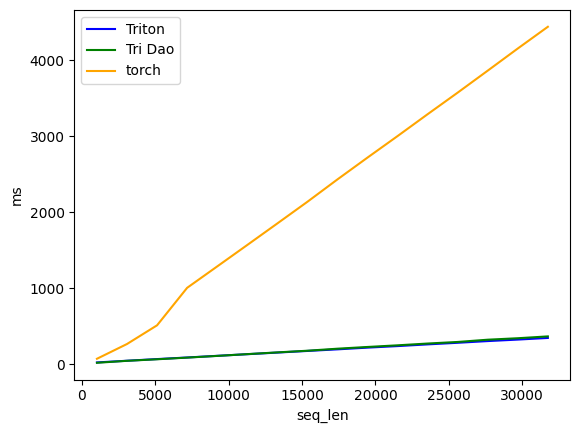

Causal Conv1d:
    seq_len      Triton     Tri Dao        torch
0    1024.0   25.880205   21.241609    74.020915
1    3072.0   48.070356   47.190387   268.281072
2    5120.0   69.957048   67.380138   514.207363
3    7168.0   90.808071   89.288734  1007.277489
4    9216.0  112.715423  111.557826  1288.639665
5   11264.0  134.034723  134.974167  1570.576072
6   13312.0  155.508786  157.792002  1853.861213
7   15360.0  176.871449  179.818884  2138.824224
8   17408.0  197.943777  206.493899  2433.331490
9   19456.0  220.543534  229.233876  2720.437765
10  21504.0  240.761772  250.865519  3003.364086
11  23552.0  263.211668  274.355263  3291.127205
12  25600.0  284.336656  295.164198  3575.031996
13  27648.0  306.770325  324.826986  3864.300728
14  29696.0  326.481551  344.143093  4155.583858
15  31744.0  348.030150  368.262738  4441.213131


In [66]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 32+1, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton', 'Tri Dao', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Tri Dao",
            "torch"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="Causal Conv1d",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 1024, 'bs': 4, 'k':4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, k, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    conv = torch.nn.Conv1d(dim, dim, kernel_size=k, groups=dim, padding=k-1, bias=False).to(dtype).to(device)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    
    if provider == 'Triton':
        ms = triton.testing.do_bench(lambda: triton_causal_conv1d(x.transpose(-1, -2), conv.weight.squeeze()))
    if provider == 'Tri Dao' and k <=4:
        ms = triton.testing.do_bench(lambda: causal_conv1d_fn(x.transpose(-1, -2), conv.weight.squeeze()))
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: conv(x.transpose(-1, -2))[..., :seq_len])

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


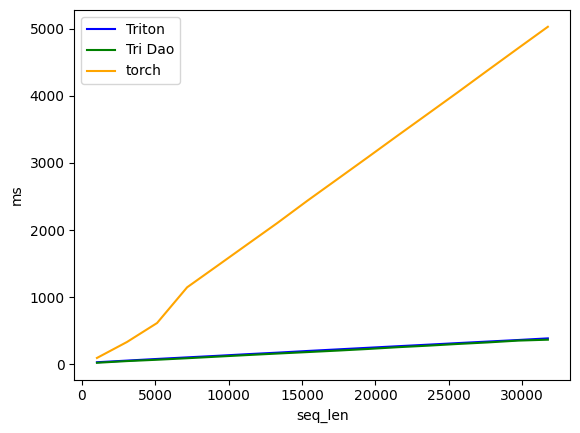

Causal Conv1d:
    seq_len      Triton     Tri Dao        torch
0    1024.0   28.956262   20.817684    92.708021
1    3072.0   53.499877   46.179403   331.010073
2    5120.0   77.993989   66.185839   613.604069
3    7168.0  101.455159   88.692307  1145.984054
4    9216.0  124.580003  112.367406  1464.869142
5   11264.0  148.964688  135.913149  1784.900904
6   13312.0  171.655387  158.484757  2104.265451
7   15360.0  196.621031  180.365369  2436.499357
8   17408.0  220.248118  202.474654  2758.360386
9   19456.0  243.898794  226.400942  3080.976486
10  21504.0  267.497987  252.925843  3406.471014
11  23552.0  290.502727  275.763303  3728.728533
12  25600.0  314.088374  301.272720  4051.842690
13  27648.0  337.208807  324.408323  4380.102158
14  29696.0  360.067606  351.377726  4706.009865
15  31744.0  384.631664  365.042865  5029.458523


In [6]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 32+1, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton', 'Tri Dao', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Tri Dao",
            "torch"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="Causal Conv1d",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 1024, 'bs': 4, 'k':4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, k, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    conv = torch.nn.Conv1d(dim, dim, kernel_size=k, groups=dim, padding=k-1, bias=False).to(dtype).to(device)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    
    if provider == 'Triton':
        ms = triton.testing.do_bench(lambda: triton_causal_conv1d(x.transpose(-1, -2), conv.weight.squeeze(), None, 'silu'))
    if provider == 'Tri Dao' and k <=4:
        ms = triton.testing.do_bench(lambda: causal_conv1d_fn(x.transpose(-1, -2), conv.weight.squeeze(), activation='silu'))
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.nn.SiLU()(conv(x.transpose(-1, -2))[..., :seq_len]))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


# backward

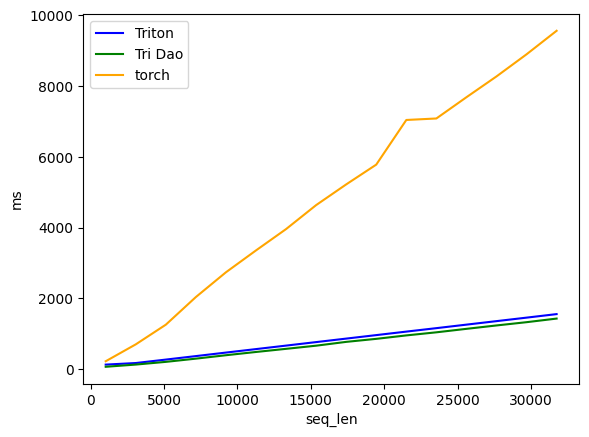

Causal Conv1d:
    seq_len       Triton      Tri Dao        torch
0    1024.0   128.298774    66.945113   223.350450
1    3072.0   172.790989   129.397810   700.261354
2    5120.0   270.155400   205.824956  1256.106734
3    7168.0   368.904144   296.655059  2037.152767
4    9216.0   468.177825   393.200547  2736.416817
5   11264.0   566.641927   485.238791  3354.240894
6   13312.0   665.129423   573.894143  3956.538439
7   15360.0   764.203191   662.824810  4633.635044
8   17408.0   862.925053   770.540953  5218.553066
9   19456.0   961.605966   855.936646  5777.555943
10  21504.0  1060.444355   953.077316  7038.701057
11  23552.0  1158.129215  1040.545583  7080.910206
12  25600.0  1257.471561  1138.653874  7681.005001
13  27648.0  1356.268764  1234.436631  8268.675804
14  29696.0  1455.133677  1326.674223  8893.651962
15  31744.0  1554.681659  1428.699136  9558.150291


In [ ]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 32+1, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton', 'Tri Dao', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Tri Dao",
            "torch"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="Causal Conv1d",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 1024, 'bs': 4, 'k':4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, k, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    x.requires_grad_(True)
    dy = torch.rand_like(x).transpose(-1, -2)
    conv = torch.nn.Conv1d(dim, dim, kernel_size=k, groups=dim, padding=k-1, bias=False).to(dtype).to(device)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    ms = 1
    if provider == 'Triton':
        y = triton_causal_conv1d(x.transpose(-1, -2), conv.weight.squeeze(), None, 'silu')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))
    if provider == 'Tri Dao' and k <=4:
        y = causal_conv1d_fn(x.transpose(-1, -2), conv.weight.squeeze(), activation='silu')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))
    if provider == 'torch':
        y = conv(x.transpose(-1, -2))[..., :seq_len]
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


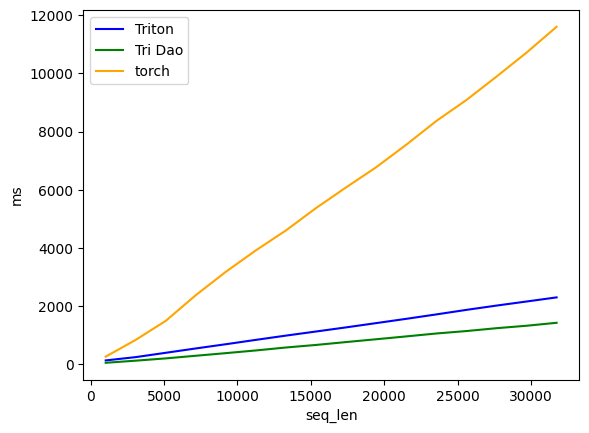

Causal Conv1d:
    seq_len       Triton      Tri Dao         torch
0    1024.0   139.250576    58.117930    268.710792
1    3072.0   252.920747   131.033927    846.082270
2    5120.0   401.665926   209.337294   1500.859857
3    7168.0   551.090360   299.748033   2383.734941
4    9216.0   696.215272   389.910936   3187.000513
5   11264.0   846.010149   482.431769   3923.974752
6   13312.0   992.531896   583.816230   4608.646393
7   15360.0  1133.202910   671.427429   5376.945496
8   17408.0  1275.299668   770.325243   6087.050438
9   19456.0  1421.623468   866.928339   6778.948307
10  21504.0  1568.641186   964.792907   7551.707268
11  23552.0  1720.397949  1064.802051   8367.506027
12  25600.0  1876.276135  1148.567438   9087.285995
13  27648.0  2023.428917  1246.405721   9890.815735
14  29696.0  2163.791656  1330.713153  10715.231895
15  31744.0  2305.154324  1432.516098  11603.472710


In [5]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 32+1, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton', 'Tri Dao', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Tri Dao",
            "torch"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="Causal Conv1d",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 1024, 'bs': 4, 'k':4}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, k, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    x.requires_grad_(True)
    dy = torch.rand_like(x).transpose(-1, -2)
    conv = torch.nn.Conv1d(dim, dim, kernel_size=k, groups=dim, padding=k-1, bias=False).to(dtype).to(device)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    ms = 1
    if provider == 'Triton':
        y = triton_causal_conv1d(x.transpose(-1, -2), conv.weight.squeeze(), None, 'silu')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))
    if provider == 'Tri Dao' and k <=4:
        y = causal_conv1d_fn(x.transpose(-1, -2), conv.weight.squeeze(), activation='silu')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))
    if provider == 'torch':
        y = conv(x.transpose(-1, -2))[..., :seq_len]
        y = torch.nn.SiLU()(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


# replace

In [1]:
from transformers import Mamba2ForCausalLM, Mamba2Config
import torch
import importlib
import causal_conv1d_triton

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [2]:
config = Mamba2Config()
config.hidden_size = 1024
config.num_heads = 16
config.num_hidden_layers = 2
config.n_groups = 8
config.head_dim = 128
config.vocab_size = 512
config.conv_kernel = 8
model = Mamba2ForCausalLM(config).to(torch.bfloat16).cuda() 

for idx,p in enumerate(model.parameters()):
    if idx == 9:
        break
def zero_grad():
    for p in model.parameters():
        if p.grad is not None:
            p.grad.zero_()


In [5]:
x = torch.arange(128).reshape(2,64).cuda()
dy = torch.randn(2, 64, config.vocab_size).to(model.dtype).to(model.device)

In [10]:
out1 = model(x).logits
out1.backward(dy)
print(out1)
print(p.grad)

tensor([[[ 4.8633e-01, -9.6094e-01, -4.0820e-01,  ..., -8.9844e-02,
           2.0898e-01,  3.7842e-02],
         [ 2.8711e-01,  9.0234e-01, -2.6123e-02,  ...,  2.7930e-01,
           5.2734e-01,  5.8594e-01],
         [ 1.2012e-01,  8.3984e-01,  8.0859e-01,  ...,  7.6953e-01,
           3.1445e-01, -1.2085e-02],
         ...,
         [ 1.4453e+00,  7.1289e-02, -4.1797e-01,  ..., -7.0312e-01,
          -7.0312e-02,  3.8281e-01],
         [ 1.2598e-01,  2.2070e-01,  2.4707e-01,  ...,  1.2500e+00,
          -7.1875e-01, -6.0938e-01],
         [-8.0078e-01, -1.8848e-01, -1.3281e-01,  ..., -1.8555e-01,
          -7.6562e-01,  1.6113e-01]],

        [[-2.5977e-01, -6.4844e-01, -1.1250e+00,  ..., -1.5723e-01,
           1.3047e+00,  8.3008e-03],
         [-3.7109e-01, -4.7266e-01, -3.9844e-01,  ..., -5.5859e-01,
          -6.4844e-01, -6.2500e-01],
         [-7.8125e-01, -2.5940e-04,  2.6172e-01,  ..., -6.9922e-01,
          -2.9297e-01, -4.3457e-02],
         ...,
         [-9.4922e-01,  2

In [2]:
from replace_conv1d_cuda import trigger

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
zero_grad()
out2 = model(x).logits
out2.backward(dy)
print(out2)
print(p.grad)

tensor([[[-7.5391e-01, -4.0625e-01, -3.6133e-01,  ..., -2.2949e-02,
          -1.9727e-01, -1.6895e-01],
         [-2.6758e-01, -6.9922e-01,  4.5312e-01,  ...,  5.7422e-01,
           1.2793e-01, -9.4141e-01],
         [-2.9492e-01, -4.6680e-01,  5.1562e-01,  ..., -1.1562e+00,
          -5.7031e-01, -5.1953e-01],
         ...,
         [-3.1738e-03,  7.1484e-01, -7.6172e-01,  ...,  6.2500e-01,
           3.0859e-01,  2.0605e-01],
         [ 3.1250e-01, -5.8203e-01,  6.8750e-01,  ..., -3.3008e-01,
           7.5000e-01,  3.2227e-01],
         [-5.5469e-01, -5.1562e-01,  3.3398e-01,  ...,  9.0332e-02,
           3.3398e-01, -1.0234e+00]],

        [[ 7.7148e-02,  4.2969e-01,  1.0986e-01,  ..., -8.5156e-01,
           3.9648e-01,  1.0000e+00],
         [ 5.0391e-01,  4.0039e-01,  4.5654e-02,  ...,  1.2793e-01,
          -9.4727e-02,  9.9609e-02],
         [-7.9102e-02,  2.8320e-01,  1.4375e+00,  ..., -6.8359e-01,
           1.2012e-01,  7.7438e-04],
         ...,
         [ 6.8359e-02, -2

In [14]:
zero_grad()
p.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.bfloat16)